In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [3]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/home/kelwa/.fastai/data/mnist.pkl.gz')

In [4]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [5]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

# Test the importing of the ds 

In [1]:
#export
import operator

def test(a, b, cmp, cname=None):
    if cname is None: cnmae=cmp.__name__
    assert cmp(a, b), f"{cname}:\n{a}\n{b}"

def test_eq(a, b): test(a, b, operator.eq, '==')

In [7]:
assert n==y_train.shape[0]==50000
test_eq(c, 28*28)
test_eq(y_train.min(), 0)
test_eq(y_train.max(), 9)

In [10]:
mpl.rcParams['image.cmap'] = 'gray'

In [11]:
img = x_train[0]

In [14]:
img.view(28, 28).type()

'torch.FloatTensor'

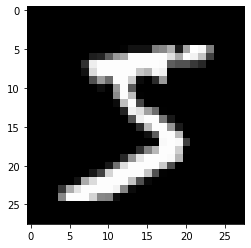

In [17]:
plt.imshow(img.view(28, 28));

In [35]:
# matrix multiplication
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(br):
                c[i, j] += a[i, k] * b[k, j]
                
    return c

In [36]:
weights = torch.randn(784, 10)
bias = torch.zeros(10)

In [37]:
m1 = x_valid[:5]
m2 = weights

In [38]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [39]:
%time t1=matmul(m1, m2)

CPU times: user 635 ms, sys: 174 µs, total: 636 ms
Wall time: 638 ms


In [40]:
t1.shape

torch.Size([5, 10])

## Speed this up 

In [64]:
# matrix multiplication
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i, j] = (a[i, :] * b[:, j]).sum()
                
    return c

In [65]:
%time new_t1=matmul(m1, m2)

CPU times: user 0 ns, sys: 2 ms, total: 2 ms
Wall time: 1.6 ms


In [70]:
%timeit -n 10 _=matmul(m1, m2)

972 µs ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [71]:
new_t1.shape

torch.Size([5, 10])

In [72]:
test_eq(t1, new_t1)

RuntimeError: bool value of Tensor with more than one value is ambiguous

In [82]:
#export
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a, b, near)

In [74]:
test_near(t1, new_t1)

### Element-wise ops 

In [55]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a, b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [56]:
a + b

tensor([12., 14.,  3.])

In [57]:
(a < b).float().mean()

tensor(0.6667)

In [58]:
(a < b)

tensor([False,  True,  True])

In [59]:
m = tensor([[1., 2, 3], [4, 5, 6], [7, 8, 9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

## Don't write `LaTeX` yourself !!
- Just copy it from anywhere

Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

In [60]:
(m*m).sum().sqrt()

tensor(16.8819)

In [87]:
# any trailing ",:" cna be removed
def matmul(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac==br, 'A columns must be equal to B rows'
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i] * b[:, j]).sum()
    return c

In [88]:
%timeit -n 10 _=matmul(m1, m2)

900 µs ± 44.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [89]:
test_near(t1,matmul(m1, m2))

## Broadcasting 

In [90]:
# with a scalar 
a

tensor([10.,  6., -4.])

In [91]:
a > 0

tensor([ True,  True, False])

0 has beed **broadcast** to have the same dimensions as **a**, so we can compare without loops

In [92]:
a+1

tensor([11.,  7., -3.])

In [93]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [95]:
# scalar to a matrix
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

### Vector to a Matrix

In [96]:
c = tensor([10., 20, 30]); c

tensor([10., 20., 30.])

In [97]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [99]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [100]:
c + m # broadcast c(1 row) to 3 rows

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [101]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [102]:
t = c.expand_as(m);

In [103]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [104]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [105]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [106]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

In [114]:
# unsqueeze
c.shape, c

(torch.Size([3]), tensor([10., 20., 30.]))

In [116]:
c.unsqueeze(0), c.unsqueeze(0).shape

(tensor([[10., 20., 30.]]), torch.Size([1, 3]))

In [117]:
c.unsqueeze(1), c.unsqueeze(1).shape

(tensor([[10.],
         [20.],
         [30.]]), torch.Size([3, 1]))

changed it to a column vector

In [118]:
c.shape, c.unsqueeze(0).shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [120]:
c[None].shape, c[..., None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

you can skip trailling ':'s and '...' means 'all preceding dimensions'

In [121]:
c[:, None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [123]:
c

tensor([10., 20., 30.])

In [124]:
c.expand_as(m)

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [122]:
c[:, None]

tensor([[10.],
        [20.],
        [30.]])

In [125]:
c[:, None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [126]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [129]:
m.sum(dim=0)

tensor([12., 15., 18.])

In [130]:
# matmul with broadcasting
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)
    return c

In [131]:
%timeit -n 10 _=matmul(m1, m2)

217 µs ± 8.91 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [132]:
885000/277

3194.945848375451

In [133]:
test_near(t1, matmul(m1, m2))

#### Broadcasting rules 

In [134]:
c, c.shape

(tensor([10., 20., 30.]), torch.Size([3]))

In [136]:
c[None,:], c[None, :].shape

(tensor([[10., 20., 30.]]), torch.Size([1, 3]))

In [137]:
c[:, None], c[:, None].shape

(tensor([[10.],
         [20.],
         [30.]]), torch.Size([3, 1]))

In [138]:
c[None, :] * c[:, None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [139]:
c[None] > c[:, None]

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

In [144]:
x = torch.arange(4, dtype=torch.float)
xx = x.view(4, 1)
y = torch.ones(5)
z = torch.ones((3, 4))

In [145]:
xx.shape, y.shape

(torch.Size([4, 1]), torch.Size([5]))

In [146]:
(xx+y).shape # should be 4x5

torch.Size([4, 5])

In [147]:
xx

tensor([[0.],
        [1.],
        [2.],
        [3.]])

In [148]:
y

tensor([1., 1., 1., 1., 1.])

In [149]:
xx+y

tensor([[1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4.]])

# Einstein Summation  

In [164]:
torch.einsum('i,i', a, b)

tensor(40.)

In [165]:
a

tensor([10.,  6., -4.])

In [152]:
torch.einsum('j', a)

tensor([10.,  6., -4.])

In [158]:
def matmul(a, b): return torch.einsum('ik,kj->ij', a, b)

In [160]:
%timeit -n 10 _=matmul(m1, m2)

33.7 µs ± 5.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [161]:
test_near(t1, matmul(m1, m2))

###  Pytorch ops

In [168]:
%timeit -n 10 t2=m1.matmul(m2)

9.48 µs ± 5.28 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [171]:
# time comparison vs pure python:
635000/9

70555.55555555556

In [172]:
t2 = m1@m2

In [173]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [3]:
!python notebook2script.py 01_matmul.ipynb

Converted 01_matmul.ipynb to exp/nb_01.py
